# data cleaning and exploration

a lot of ideas come from fourski1ng [github](https://github.com/foursking1/jd)

In [1]:
# -*- coding: UTF-8 -*-
import time
from datetime import datetime
from datetime import timedelta
import pandas as pd
import pickle
import os
import math
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('ggplot')
%matplotlib inline

action_1_path = "./data/JData_Action_201602.csv"
action_2_path = "./data/JData_Action_201603.csv"
action_3_path = "./data/JData_Action_201604.csv"
comment_path = "./data/JData_Comment.csv"
product_path = "./data/JData_Product.csv"
user_path = "./data/JData_User.csv"

# user data

from jd

|user_id|用户ID|脱敏|
|-------|-----|-----|
|age|年龄段|-1表示未知|
|sex|性别|0表示男，1表示女，2表示保密|
|user_lv_cd|用户等级|有顺序的级别枚举，越高级别数字越大|
|user_reg_tm|用户注册日期|粒度到天|


In [2]:
user = pd.read_csv(user_path, encoding='gbk')
user.user_reg_tm = pd.to_datetime(user.user_reg_tm)
user.head(2)

,user_id,age,sex,user_lv_cd,user_reg_tm
0,200001,56岁以上,2,5,2016-01-26
1,200002,-1,0,1,2016-01-26


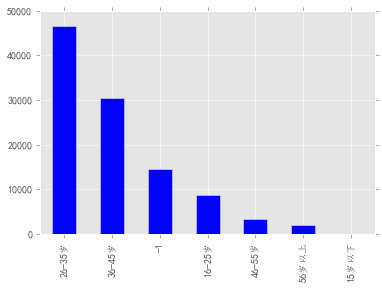

In [3]:
# age plot
user.age.value_counts().plot.bar()

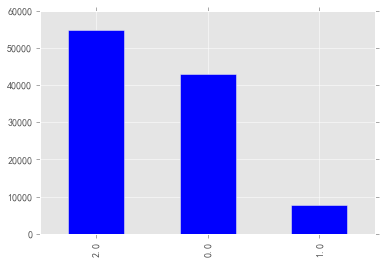

In [4]:
# sex plot
user.sex.value_counts().plot.bar()

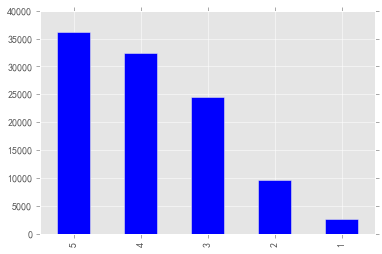

In [5]:
# level plot
user.user_lv_cd.value_counts().plot.bar()

In [6]:
# users that registered after the test period
test_date = datetime(2016, 4, 16)

user.user_reg_tm = pd.to_datetime(user.user_reg_tm)
user[user.user_reg_tm > test_date].head()

,user_id,age,sex,user_lv_cd,user_reg_tm
8545,208546,16-25岁,0,2,2016-04-29
9394,209395,16-25岁,1,2,2016-05-11
10362,210363,56岁以上,2,2,2016-05-24
10367,210368,-1,2,1,2016-05-24
11019,211020,36-45岁,2,3,2016-06-06


In [7]:
# select registed user before the test period
user_with_valid_reg_date = user[(user.user_reg_tm < test_date)]
user_with_valid_reg_date.user_reg_tm.describe()

count                  105309
unique                   3447
top       2015-11-11 00:00:00
freq                      412
first     2003-06-16 00:00:00
last      2016-04-15 00:00:00
Name: user_reg_tm, dtype: object

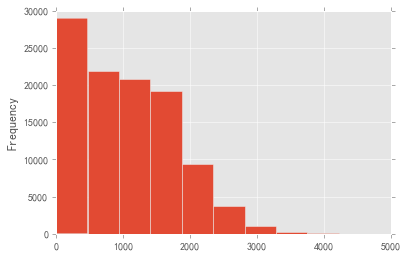

In [8]:
# the days customers registered at 2016-04-15

reg_days = user_with_valid_reg_date.user_reg_tm.map(lambda x:(test_date - x).days)
reg_days.plot.hist()

In [9]:
# ETL
def convert_age(age_str):
    if age_str == u'-1':
        return 0
    elif age_str == u'15岁以下':
        return 1
    elif age_str == u'16-25岁':
        return 2
    elif age_str == u'26-35岁':
        return 3
    elif age_str == u'36-45岁':
        return 4
    elif age_str == u'46-55岁':
        return 5
    elif age_str == u'56岁以上':
        return 6
    else:
        return -1

def get_basic_user_feat():
    dump_path = './cache/basic_user.pkl'
    if os.path.exists(dump_path):
        user = pickle.load(open(dump_path))
    else:
        user = pd.read_csv(user_path, encoding='gbk')
        user['age'] = user['age'].map(convert_age)
        age_df = pd.get_dummies(user["age"], prefix="age")
        sex_df = pd.get_dummies(user["sex"], prefix="sex")
        user_lv_df = pd.get_dummies(user["user_lv_cd"], prefix="user_lv_cd")
        user_mat = pd.concat([user[['user_id', 'user_reg_tm']], age_df, sex_df, user_lv_df], axis=1)
        
        user_mat.user_reg_tm = pd.to_datetime(user_mat.user_reg_tm)
        user_with_valid_reg_date = user_mat[(user_mat.user_reg_tm < test_date)]
        user_with_valid_reg_date['reg_days'] = user_with_valid_reg_date.user_reg_tm.map(lambda x:(test_date - x).days)
        # user_processed = user_with_valid_reg_date.drop('user_reg_tm', 1)
        
        # pickle.dump(user, open(dump_path, 'w'))
    return user_with_valid_reg_date

In [10]:
user_tr = get_basic_user_feat()

C:\Anaconda\envs\phd_conda\lib\site-packages\ipykernel\__main__.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Product

商品数据

|sku_id|商品编号|脱敏|
|------|--------|----|
|a1|属性1|枚举，-1表示未知|
|a2|属性2|枚举，-1表示未知|
|a3|属性3|枚举，-1表示未知|
|cate|品类ID|脱敏|
|brand|品牌ID|脱敏|

In [11]:
product = pd.read_csv(product_path)
product.head()

,sku_id,a1,a2,a3,cate,brand
0,10,3,1,1,8,489
1,100002,3,2,2,8,489
2,100003,1,-1,-1,8,30
3,100006,1,2,1,8,545
4,10001,-1,1,2,8,244


only one category of products

In [12]:
# only testing cate8
product.cate.value_counts()

8    24187
Name: cate, dtype: int64

In [13]:
# brands with most products
product.groupby('brand').size().nlargest(10)

brand
489    6637
214    6444
623    1101
812    1061
800    1015
545     945
124     932
306     795
30      659
885     601
dtype: int64

In [14]:
# ETL
def get_basic_product_feat():
#     dump_path = './cache/basic_product.pkl'
#     if os.path.exists(dump_path):
#         product = pickle.load(open(dump_path))
#    else:
    product = pd.read_csv(product_path)
    attr1_df = pd.get_dummies(product["a1"], prefix="a1")
    attr2_df = pd.get_dummies(product["a2"], prefix="a2")
    attr3_df = pd.get_dummies(product["a3"], prefix="a3")
    product = pd.concat([product[['sku_id', 'cate', 'brand']], attr1_df, attr2_df, attr3_df], axis=1)
#         pickle.dump(product, open(dump_path, 'w'))
    return product

In [15]:
product_tr = get_basic_product_feat()

In [16]:
product_tr.head()

,sku_id,cate,brand,a1_-1,a1_1,a1_2,a1_3,a2_-1,a2_1,a2_2,a3_-1,a3_1,a3_2
0,10,8,489,0,0,0,1,0,1,0,0,1,0
1,100002,8,489,0,0,0,1,0,0,1,0,0,1
2,100003,8,30,0,1,0,0,1,0,0,1,0,0
3,100006,8,545,0,1,0,0,0,0,1,0,1,0
4,10001,8,244,1,0,0,0,0,1,0,0,0,1


## attempt to cluster products

In [17]:
# Kmeans
import numpy as np
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

np.random.seed(5)

kmeans = KMeans(n_clusters=2, random_state=0).fit(product_tr)
labels = kmeans.labels_

In [18]:
product["label"] = labels
product.label.value_counts()

1    12154
0    12033
Name: label, dtype: int64

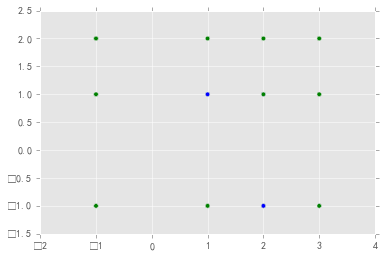

In [19]:
colors = ["b", "g", "r"]
product["color"] = product.label.map(lambda x: colors[x])

plt.scatter(product.a1, product.a2, c=product.color)

# Comment

评价数据

|Name|explaination|data|
|-|-|-|
|dt|  截止到时间|   粒度到天|
|sku_id|  商品编号|    脱敏|
|comment_num|累计评论数分段 |0表示无评论，1表示有1条评论，2表示有2-10条评论，3表示有11-50条评论，4表示大于50条评论|
|has_bad_comment|     是否有差评|   0表示无，1表示有|
|bad_comment_rate|    差评率|     差评数占总评论数的比重|

In [20]:
comments = pd.read_csv(comment_path)

In [21]:
comments.head()

,dt,sku_id,comment_num,has_bad_comment,bad_comment_rate
0,2016-02-01,1000,3,1,0.0417
1,2016-02-01,10000,2,0,0.0000
2,2016-02-01,100011,4,1,0.0376
3,2016-02-01,100018,3,0,0.0000
4,2016-02-01,100020,3,0,0.0000


In [22]:
# todo: ETL

# Action

|Name|explaination|data|
|-|-|-|
|user_id     |用户编号    |脱敏|
|sku_id  |商品编号    |脱敏|
|time    |行为时间    ||
|model_id    |点击模块编号，如果是点击    |脱敏|
|type |1.浏览（指浏览商品详情页）；2.加入购物车；3.购物车删除；4.下单；5.关注；6.点击 ||
|cate |   品类ID    |脱敏|
|brand   |品牌ID|

In [23]:
action_paths = [action_1_path, action_2_path, action_3_path]
action1, action2, action3 = [pd.read_csv(p) for p in action_paths]

In [24]:
action1.head()

,user_id,sku_id,time,model_id,type,cate,brand
0,266079,138778,2016-01-31 23:59:02,NaN,1,8,403
1,266079,138778,2016-01-31 23:59:03,0,6,8,403
2,200719,61226,2016-01-31 23:59:07,NaN,1,8,30
3,200719,61226,2016-01-31 23:59:08,0,6,8,30
4,263587,72348,2016-01-31 23:59:08,NaN,1,5,159


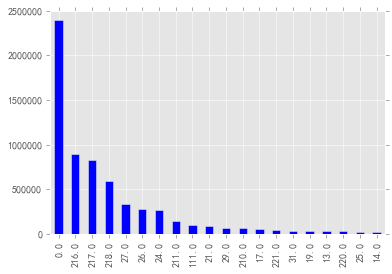

In [25]:
# about model id
action1.model_id.value_counts().nlargest(20).plot.bar()

In [26]:
# action counts
action1.type.value_counts()

6    6690425
1    4554840
2     140727
3      58917
5      29030
4      11485
Name: type, dtype: int64

In [27]:
# data available for cate 8 and others
action1.cate.value_counts()

8     3194275
4     2918671
6     1642371
5     1483361
7     1126849
9      888435
10     211572
11      19890
Name: cate, dtype: int64

# dump the data processed

In [29]:
dump_folder = "./data"
processed_data = [user_tr, product_tr]
processed_data_name = ["users", "products"]

for data, data_name in zip(processed_data, processed_data_name):
    pickle.dump(data, open(os.path.join(dump_folder, data_name), 'w'))